<a href="https://colab.research.google.com/github/Aker490/45/blob/main/CoverGen_No_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/ardha27/AICoverGen-NoUI-Colab

In [4]:
!apt-get update -y
!apt-get install python3.9 python3.9-distutils
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!update-alternatives --config python3
!apt-get install python3-pip
!python3 -m pip install --upgrade pip --user
!python --version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

In [5]:
#@title Clone repository
!git clone https://github.com/SociallyIneptWeeb/AICoverGen.git
%cd AICoverGen

Cloning into 'AICoverGen'...
remote: Enumerating objects: 369, done.
remote: Total 369 (delta 0), reused 0 (delta 0), pack-reused 369 (from 1)
Receiving objects: 100% (369/369), 1.80 MiB | 28.81 MiB/s, done.
Resolving deltas: 100% (230/230), done.
/content/AICoverGen


In [ ]:
#@title Install requirements
!python -m pip install pip==23.0.1
!pip install -r requirements.txt
!sudo apt update
!sudo apt install sox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.1/213.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/22

In [ ]:
#@title Download MDXNet Vocal Separation and Hubert Base Models
!python src/download_models.py

In [ ]:
#@title Model Download Function

import os
import zipfile
import shutil
import urllib.request

BASE_DIR = os.getcwd()
rvc_models_dir = os.path.join(BASE_DIR, 'rvc_models')

def extract_zip(extraction_folder, zip_name):
    os.makedirs(extraction_folder)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extraction_folder)
    os.remove(zip_name)

    index_filepath, model_filepath = None, None
    for root, dirs, files in os.walk(extraction_folder):
        for name in files:
            if name.endswith('.index') and os.stat(os.path.join(root, name)).st_size > 1024 * 100:
                index_filepath = os.path.join(root, name)

            if name.endswith('.pth') and os.stat(os.path.join(root, name)).st_size > 1024 * 1024 * 40:
                model_filepath = os.path.join(root, name)

    if not model_filepath:
        raise Exception(f'No .pth model file was found in the extracted zip. Please check {extraction_folder}.')

    # move model and index file to extraction folder
    os.rename(model_filepath, os.path.join(extraction_folder, os.path.basename(model_filepath)))
    if index_filepath:
        os.rename(index_filepath, os.path.join(extraction_folder, os.path.basename(index_filepath)))

    # remove any unnecessary nested folders
    for filepath in os.listdir(extraction_folder):
        if os.path.isdir(os.path.join(extraction_folder, filepath)):
            shutil.rmtree(os.path.join(extraction_folder, filepath))

def download_online_model(url, dir_name):
    try:
        print(f'[~] Downloading voice model with name {dir_name}...')
        zip_name = url.split('/')[-1]
        extraction_folder = os.path.join(rvc_models_dir, dir_name)
        if os.path.exists(extraction_folder):
            raise Exception(f'Voice model directory {dir_name} already exists! Choose a different name for your voice model.')

        if 'pixeldrain.com' in url:
            url = f'https://pixeldrain.com/api/file/{zip_name}'

        urllib.request.urlretrieve(url, zip_name)

        print('[~] Extracting zip...')
        extract_zip(extraction_folder, zip_name)
        print(f'[+] {dir_name} Model successfully downloaded!')

    except Exception as e:
        raise Exception(str(e))

url = "https://pixeldrain.com/u/3tJmABXA" # @param {type:"string"}
dir_name = "Gura" # @param {type:"string"}

download_online_model(url, dir_name)

In [ ]:
# @title Generate | Output generated inside "AICoverGen\song_output\random_number"
# @markdown Main Option | You also can input audio path inside "SONG_INPUT"
SONG_INPUT = "https://www.youtube.com/watch?v=jgCVkQhlScc&pp=ygUFY3VwaWQ%3D" # @param {type:"string"}
RVC_DIRNAME = "Gura" # @param {type:"string"}
PITCH_CHANGE = 0 # @param {type:"integer"}
PITCH_CHANGE_ALL = 0 # @param {type:"integer"}
# @markdown Voice Conversion Options
INDEX_RATE = 0.5 # @param {type:"number"}
FILTER_RADIUS = 3 # @param {type:"integer"}
PITCH_DETECTION_ALGO = "rmvpe" # @param ["rmvpe", "mangio-crepe"]
CREPE_HOP_LENGTH = 128 # @param {type:"integer"}
PROTECT = 0.33 # @param {type:"number"}
REMIX_MIX_RATE = 0.25  # @param {type:"number"}
# @markdown Audio Mixing Options
MAIN_VOL = 0 # @param {type:"integer"}
BACKUP_VOL = 0 # @param {type:"integer"}
INST_VOL = 0 # @param {type:"integer"}
# @markdown Reverb Control
REVERB_SIZE = 0.15 # @param {type:"number"}
REVERB_WETNESS = 0.2 # @param {type:"number"}
REVERB_DRYNESS = 0.8 # @param {type:"number"}
REVERB_DAMPING = 0.7 # @param {type:"number"}
# @markdown Output Format
OUTPUT_FORMAT = "mp3" # @param ["mp3", "wav"]

import subprocess

command = [
    "python",
    "src/main.py",
    "-i", SONG_INPUT,
    "-dir", RVC_DIRNAME,
    "-p", str(PITCH_CHANGE),
    "-k",
    "-ir", str(INDEX_RATE),
    "-fr", str(FILTER_RADIUS),
    "-rms", str(REMIX_MIX_RATE),
    "-palgo", PITCH_DETECTION_ALGO,
    "-hop", str(CREPE_HOP_LENGTH),
    "-pro", str(PROTECT),
    "-mv", str(MAIN_VOL),
    "-bv", str(BACKUP_VOL),
    "-iv", str(INST_VOL),
    "-pall", str(PITCH_CHANGE_ALL),
    "-rsize", str(REVERB_SIZE),
    "-rwet", str(REVERB_WETNESS),
    "-rdry", str(REVERB_DRYNESS),
    "-rdamp", str(REVERB_DAMPING),
    "-oformat", OUTPUT_FORMAT
]

# Open a subprocess and capture its output
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)

# Print the output in real-time
for line in process.stdout:
    print(line, end='')

# Wait for the process to finish
process.wait()

Example of generated audio path

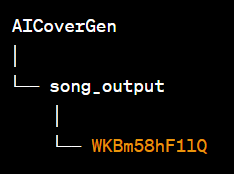